In [4]:
#!pip install openpyxl
#https://clio-infra.eu/Indicators/Height.html

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.mode.chained_assignment = None
df_var = pd.read_excel('other_data/InfantMortality_Compact.xlsx', sheet_name='Data Long Format')
df_var

,ccode,country.name,year,value
0,191,Croatia,1810,175.00000
1,246,Finland,1810,200.10000
2,826,United Kingdom,1810,141.00000
3,40,Austria,1820,187.80000
4,191,Croatia,1820,150.00000
...,...,...,...,...
655,764,Thailand,2000,2.53333
656,270,The Gambia,2000,77.83330
657,800,Uganda,2000,91.50000
658,860,Uzbekistan,2000,71.90000


<Axes: >

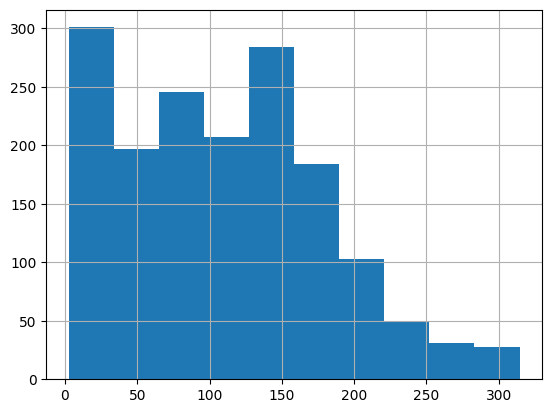

In [5]:

var = 'infant_mortality'

df_var = df_var.rename(columns={'value':var, 'country.name':'name'})
df_var = df_var.sort_values(var, ascending=False)


df_var = df_var.drop('name', axis=1)
df_ccode_iso = pd.read_csv('other_data/ccode_iso3.csv')
df_ccode_iso = df_ccode_iso[['name', 'country-code', 'alpha-3']]
df_ccode_iso.columns = ['name', 'ccode', 'iso_a3'].copy()

df_var = pd.merge(df_var, df_ccode_iso, on = 'ccode')

# load regions and equivalent country_name
df_regions_culture = pd.read_csv('other_data/ENS - Cultural Index - Countries Databases - consolidate_table.csv')
df_regions_culture = df_regions_culture[['region', 'iso_a3']].drop_duplicates()

df_var = pd.merge(df_var, df_regions_culture, on = 'iso_a3')
df_var = df_var.rename(columns={'name':'country_name'})
#df_var[var]=df_var[var] + abs(min(df_var[var]))

# Normalize the wellbeing column
# min_val = df_var[var].min()
# max_val = df_var[var].max()

# df_var[var] = (df_var[var] - min_val) / (max_val - min_val)

# df_var = df_var[df_var['wellbeing']>0]
df_var[var].hist()


### Population (Maddison + Interpolation for every year)

In [6]:
df_population_interpolated = pd.read_csv('other_data/population_interpolated.csv', index_col=[0])
df_iso = pd.read_csv('other_data/iso.csv', index_col = [0])
df_population_interpolated = pd.merge(df_population_interpolated, df_iso, on = 'country_name')
df_population_interpolated

,country_name,year,pop,iso_a3
0,Albania,1,200.0,ALB
1,Albania,2,200.0,ALB
2,Albania,3,200.0,ALB
3,Albania,4,200.0,ALB
4,Albania,5,200.0,ALB
...,...,...,...,...
79336,Viet Nam,1896,10528.0,VNM
79337,Viet Nam,1897,10528.0,VNM
79338,Viet Nam,1898,10528.0,VNM
79339,Viet Nam,1899,10528.0,VNM


In [7]:
var_weighted = f'{var}_weighted'

df_var_pop = pd.merge(df_var, df_population_interpolated, on = ['year','iso_a3'])

df_var_w = df_var_pop.groupby(['region', 'year']).apply(lambda x: (x[var] * x['pop']).sum() / x['pop'].sum())
df_var_w = df_var_w.reset_index()
df_var_w = df_var_w.rename(columns={0: var_weighted})
df_var_w = df_var_w[df_var_w['year']<=1880]

df_var_w['decade'] = df_var_w['year'].apply(lambda x: round(x / 10) * 10)
df_var_w = df_var_w.groupby(['region', 'decade'])[var_weighted].mean().reset_index()
df_var_w.to_csv('other_data/f{var}_weighted_pop_decade.csv')

### Visualize

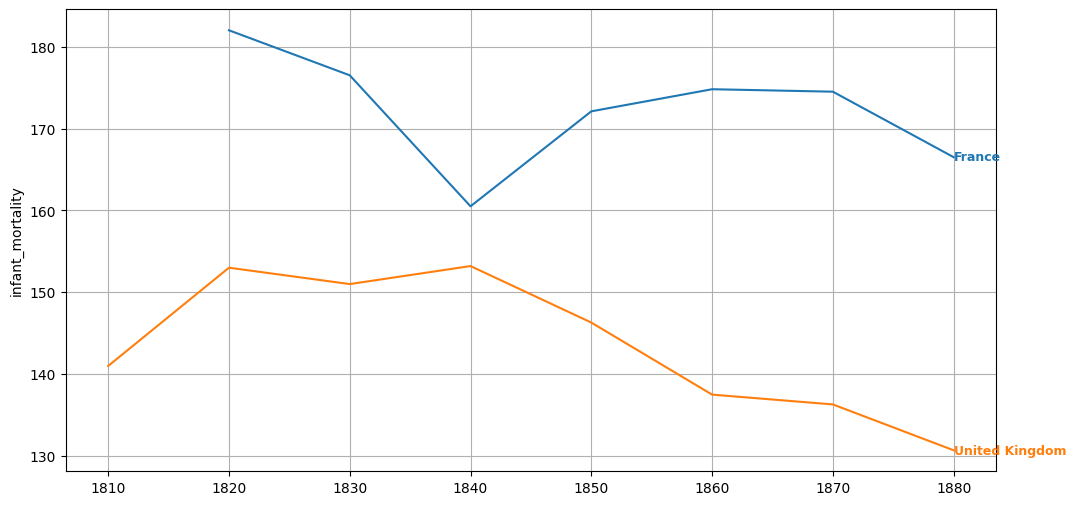

In [8]:
import matplotlib.pyplot as plt

df_fig = df_var_w[df_var_w['region'].isin(['France', 'Italy', 'Chinese world', 'United Kingdom', 'Arabic world'])]

# Re-plotting with country labels near each line
plt.figure(figsize=(12, 6))

for region in df_fig['region'].unique():
    subset = df_fig[df_fig['region'] == region]
    line = plt.plot(subset['decade'], subset[var_weighted], label=region)  # Store the line object
    
    # Get the color of the line
    line_color = line[0].get_color()  # Get the color of the first line (since the plot returns a list)
    
    # Adding text label near the end of each line with the same color as the line
    plt.text(subset['decade'].values[-1], subset[var_weighted].values[-1], region, 
             verticalalignment='center', fontsize=9, weight='bold', color=line_color)

# Adding plot details
plt.title("")
plt.xlabel("")
plt.ylabel(var)
plt.grid(visible=True)

plt.show()

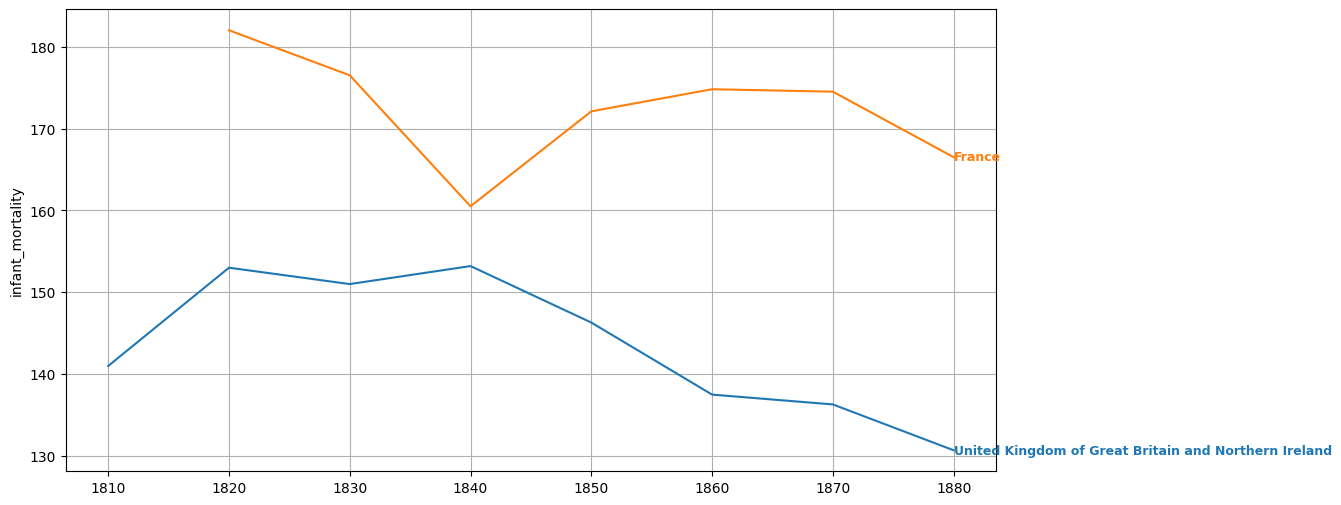

In [9]:
import matplotlib.pyplot as plt

df_fig = df_var[['year', 'country_name', var]].drop_duplicates()
df_fig = df_fig[df_fig['country_name'].isin(['France', 'Italy', 'China', 'United Kingdom of Great Britain and Northern Ireland'])]
df_fig = df_fig.sort_values(['year', 'country_name'])
df_fig = df_fig[df_fig['year']<=1880]


# Re-plotting with country labels near each line
plt.figure(figsize=(12, 6))

for region in df_fig['country_name'].unique():
    subset = df_fig[df_fig['country_name'] == region]
    line = plt.plot(subset['year'], subset[var], label=region)  # Store the line object
    
    # Get the color of the line
    line_color = line[0].get_color()  # Get the color of the first line (since the plot returns a list)
    
    # Adding text label near the end of each line with the same color as the line
    plt.text(subset['year'].values[-1], subset[var].values[-1], region, 
             verticalalignment='center', fontsize=9, weight='bold', color=line_color)

# Adding plot details
plt.title("")
plt.xlabel("")
plt.ylabel(var)
plt.grid(visible=True)
plt.show()


### Correlation with the PCI

In [10]:
### Load CPI
path = 'unseen_species_model/unseen_species_model_bayesian.csv'

df_cultura = pd.read_csv(path, index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura.head(10)


,region_name,decade,N_est,score
0,Arabic world,-610,5.529170,1
1,Arabic world,-400,2.611448,1
2,Arabic world,-360,14.825990,3
3,Arabic world,-330,6.061846,1
4,Arabic world,-310,6.022250,1
5,Arabic world,-300,24.011958,4
6,Arabic world,-280,5.966345,1
7,Arabic world,-270,23.797637,4
8,Arabic world,-260,11.867531,2
9,Arabic world,-250,5.919737,1


In [11]:
df_var_w = df_var_w.rename(columns={"region": "region_name"})

In [12]:
df = pd.merge(df_var_w, df_cultura, on = ['region_name', 'decade'])
df = df.rename(columns = {'decade': 'year'})
df.head(10)


,region_name,year,infant_mortality_weighted,N_est,score
0,Central Europe,1850,252.5,28454.914955,685
1,Central Europe,1860,240.0,36453.488381,900
2,Central Europe,1880,147.5,57791.582171,1404
3,France,1820,182.0,12611.867746,813
4,France,1830,176.5,12294.782460,903
5,France,1840,160.5,22397.642731,1556
6,France,1850,172.1,22275.014487,1527
7,France,1860,174.8,29344.996514,1955
8,France,1870,174.5,21566.526049,1432
9,France,1880,166.5,32132.232209,2090


In [13]:


list(set(df.region_name))
df.region_name.value_counts()

keep = ['Indian world',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'United Kingdom',
 'France',
 'Greek World',
 'Arabic world',
 'Chinese world',
 'Japan',
 'German world',
 'Low countries',
 'Italy',
 'Korea',
 'Spain']

# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["N_est_log"] = np.log(df["N_est"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["N_est_std"] = df["N_est"] / df["N_est"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()
df[f"log_{var}"] = np.log(df[f"{var}_weighted"])
df[f"log_{var}_std"] = df[f"log_{var}"] / df[f"log_{var}"].mean()
df[f"{var}_std"] = df[f"{var}_weighted"] / df[f"{var}_weighted"].mean()

df = df[df['region_name'].isin(keep)]
df

,region_name,year,infant_mortality_weighted,N_est,score,century,score_log,N_est_log,score_log_std,N_est_std,N_est_log_std,log_infant_mortality,log_infant_mortality_std,infant_mortality_std
3,France,1820,182.000000,12611.867746,813,1800,6.700731,9.442394,1.019739,0.373411,0.986737,5.204007,1.005184,1.003023
4,France,1830,176.500000,12294.782460,903,1800,6.805723,9.416930,1.035717,0.364023,0.984076,5.173321,0.999256,0.972712
5,France,1840,160.500000,22397.642731,1556,1800,7.349874,10.016711,1.118527,0.663148,1.046754,5.078294,0.980901,0.884534
6,France,1850,172.100000,22275.014487,1527,1800,7.331060,10.011221,1.115664,0.659517,1.046180,5.148076,0.994380,0.948463
7,France,1860,174.800000,29344.996514,1955,1900,7.578145,10.286877,1.153266,0.868845,1.074986,5.163642,0.997387,0.963343
8,France,1870,174.500000,21566.526049,1432,1900,7.266827,9.978898,1.105889,0.638540,1.042802,5.161925,0.997055,0.961690
9,France,1880,166.500000,32132.232209,2090,1900,7.644919,10.377615,1.163428,0.951369,1.084468,5.114995,0.987990,0.917601
10,German world,1820,187.800000,45841.434942,1312,1800,7.179308,10.732944,1.092570,1.357270,1.121601,5.235378,1.011243,1.034988
11,German world,1830,289.205446,48888.656131,1433,1800,7.267525,10.797301,1.105995,1.447492,1.128326,5.667137,1.094640,1.593845
12,German world,1840,292.570048,79114.510007,2571,1800,7.852050,11.278652,1.194950,2.342417,1.178627,5.678704,1.096874,1.612388


                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_infant_mortality_std
No. Observations: 44      Method:             REML                    
No. Groups:       6       Scale:              0.0004                  
Min. group size:  7       Log-Likelihood:     92.1388                 
Max. group size:  8       Converged:          Yes                     
Mean group size:  7.3                                                 
------------------------------------------------------------------------
                    Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
------------------------------------------------------------------------
Intercept            1.125      0.073   15.496   0.000    0.982    1.267
N_est_log_std       -0.133      0.072   -1.837   0.066   -0.274    0.009
Group Var            0.003      0.109                                   



/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(0.0, 1.0, 0.0, 1.0)

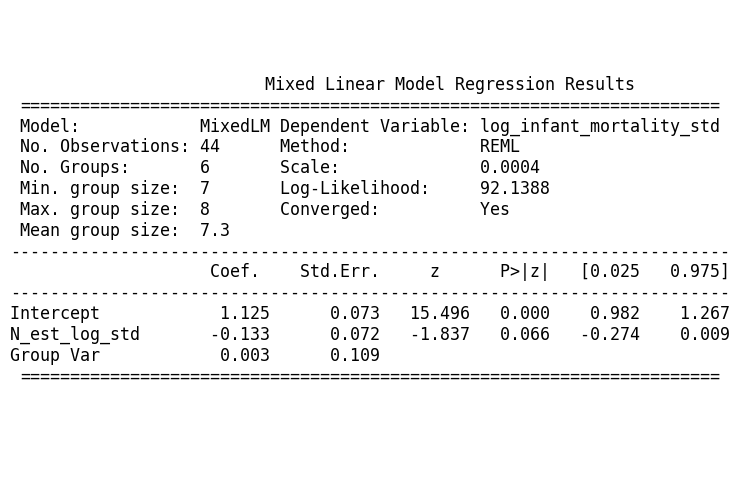

In [14]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

df_ols = df[['region_name', 'year', f'log_{var}_std', 'N_est_log_std', 'score_log_std']].copy()

# Mixed Effects Model
model = smf.mixedlm(f"log_{var}_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()


sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'Corrected CPI'
sm_table = sm_table.reset_index()


# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())


# Plotting the summary text
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.5, 0.5, result.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
ax.axis('off')  # Turn off the axis

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_78256/2205678226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_78256/2205678226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_78256/2205678226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_78256/22056

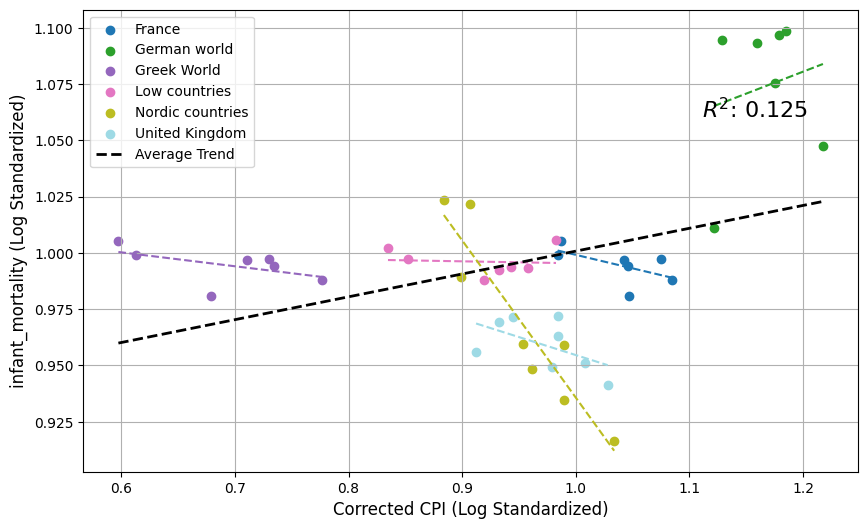

In [15]:
cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols(f"log_{var}_std ~ N_est_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['N_est_log_std'], group[f'log_{var}_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['N_est_log_std'].min(), group['N_est_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['N_est_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols(f"log_{var}_std ~ N_est_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('Corrected CPI (Log Standardized)', fontsize=12)
plt.ylabel(f'{var} (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Display R-squared for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_infant_mortality_std
No. Observations: 44      Method:             REML                    
No. Groups:       6       Scale:              0.0004                  
Min. group size:  7       Log-Likelihood:     95.2520                 
Max. group size:  8       Converged:          Yes                     
Mean group size:  7.3                                                 
-------------------------------------------------------------------------
                Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
-------------------------------------------------------------------------
Intercept        1.373       0.129    10.662    0.000     1.121     1.625
log_gdp_std     -0.375       0.128    -2.936    0.003    -0.625    -0.125
Group Var        0.002       0.053                                       



/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(0.0, 1.0, 0.0, 1.0)

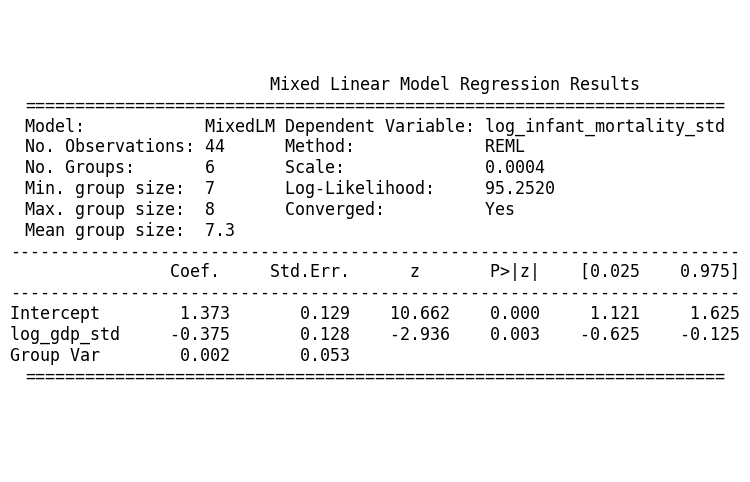

In [18]:
df_gdp = pd.read_csv("other_data/gdp_weighted_pop_decade.csv")
df_gdp = df_gdp.rename(columns={"region": "region_name", "decade":"year",'gdp_pc_weighted':'gdp_per_capita'})

new_df = pd.merge(df, df_gdp, on = ["region_name","year"])
new_df["log_gdp"] = np.log(new_df["gdp_per_capita"])
new_df["log_gdp_std"] = new_df["log_gdp"] / new_df["log_gdp"].mean()


df_ols = new_df[['region_name', 'year', f'log_{var}_std', 'log_gdp_std']].copy()

# Mixed Effects Model
model = smf.mixedlm(f"log_{var}_std ~ log_gdp_std", df_ols, groups=df_ols["region_name"])
result = model.fit()

sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'Corrected CPI'
sm_table = sm_table.reset_index()

# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())


# Plotting the summary text
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.5, 0.5, result.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
ax.axis('off')  # Turn off the axis

<!-- ### Load Culture -->